# **Image Colorization using Deep Learning**

One of the most fascinating applications of deep learning is the colorization of black and white images. Just a few years ago, this task required extensive manual effort and rule-based programming. Today, thanks to deep learning, it's possible to build an end-to-end solution that automates the entire process.

In this project we'll experiment with various model architectures and find an efficient approach that delivers impressive results even on a relatively small dataset and with minimal training time.

## Introduction to Colorization Problem

Given a grayscale image, the goal is to predict colors for each pixel.

Traditonal approaches involved simple heuristics and manual rules for adding color to grayscale images.

Deep learning automates this process


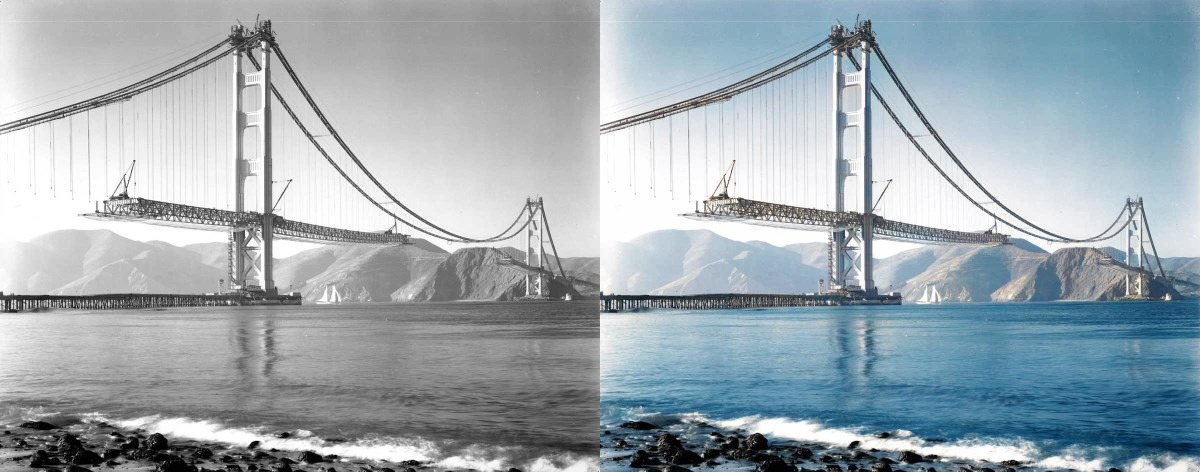

### RGB vs LAB

RGB data represent color in RGB color space and there are 3 numbers for each pixel indicating how much Red, Green, and Blue the pixel is.

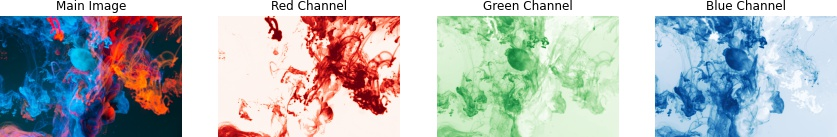

In L*a*b color space, we have again three numbers for each pixel but these numbers have different meanings. The first number (channel), L, encodes the Lightness of each pixel and when we visualize this channel (the second image in the row below) it appears as a black and white image. The *a and *b channels encode how much green-red and yellow-blue each pixel is, respectively. In the following image you can see each channel of L*a*b color space separately.

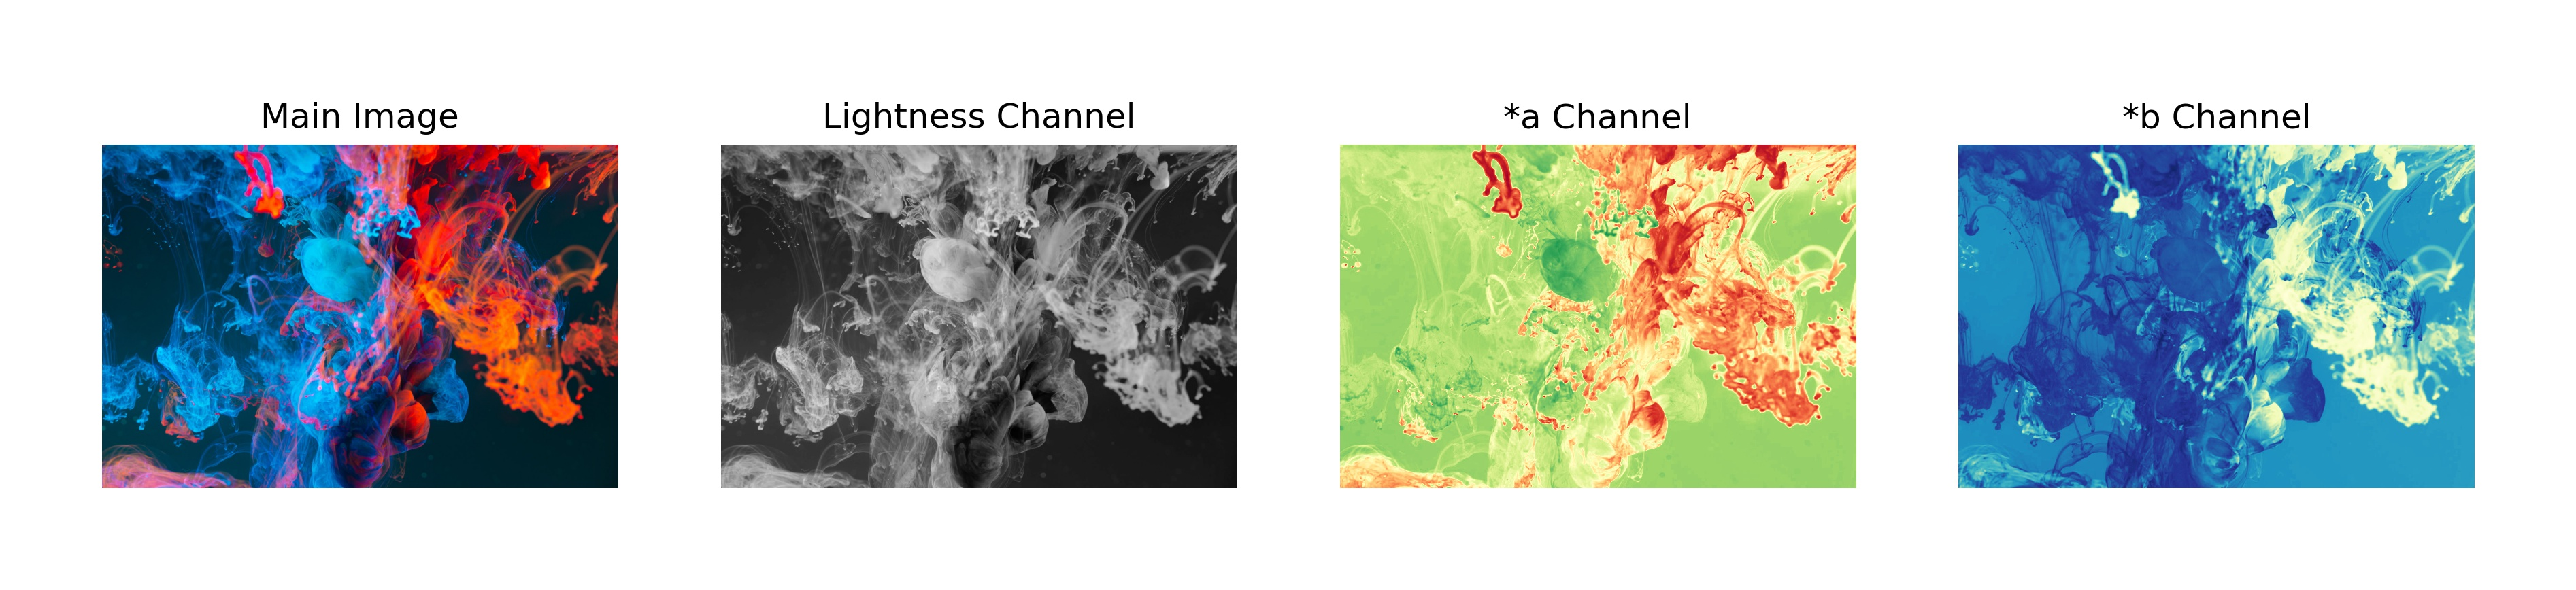

## 1-Loading the necessary Libraries

In [ ]:
!pip install tensorflow

In [ ]:
!pip install opencv-python

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import cv2
import skimage.color as sk
from tqdm import tqdm_notebook as tqdm

### 1.1-Mounting the drive and loading image paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path="/content/drive/MyDrive/Landscapes_snapshots"
paths="/content/drive/MyDrive/Landscapes_snapshots/landscapes"

In [ ]:
import os
image_paths=[os.path.join(paths,img) for
             img in os.listdir(paths) if
             img.endswith(('.jpg','.png','.jpeg'))]

print(image_paths)

['/content/drive/MyDrive/Landscapes_snapshots/landscapes/00000019 (5).jpg', '/content/drive/MyDrive/Landscapes_snapshots/landscapes/00000008 (3).jpg', '/content/drive/MyDrive/Landscapes_snapshots/landscapes/00000039 (2).jpg', '/content/drive/MyDrive/Landscapes_snapshots/landscapes/00000034 (3).jpg', '/content/drive/MyDrive/Landscapes_snapshots/landscapes/00000006 (2).jpg', '/content/drive/MyDrive/Landscapes_snapshots/landscapes/00000010.jpg', '/content/drive/MyDrive/Landscapes_snapshots/landscapes/00000015 (7).jpg', '/content/drive/MyDrive/Landscapes_snapshots/landscapes/00000006 (4).jpg', '/content/drive/MyDrive/Landscapes_snapshots/landscapes/00000023 (7).jpg', '/content/drive/MyDrive/Landscapes_snapshots/landscapes/00000017 (4).jpg', '/content/drive/MyDrive/Landscapes_snapshots/landscapes/00000015 (2).jpg', '/content/drive/MyDrive/Landscapes_snapshots/landscapes/00000010 (5).jpg', '/content/drive/MyDrive/Landscapes_snapshots/landscapes/00000022 (4).jpg', '/content/drive/MyDrive/Land

In [ ]:
print(len(image_paths))

4330


## 2-Displaying images

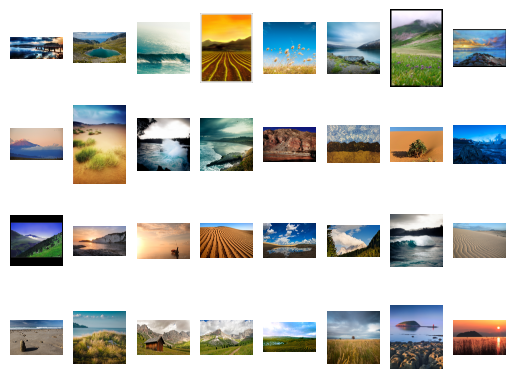

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
selected_paths=image_paths[:32]
fig,axes=plt.subplots(4,8,)
figsize=(32,12)
fig.subplots_adjust(wspace=0.2,hspace=0.2)

for ax,img_path in zip(axes.flat,selected_paths):
  img=Image.open(img_path)
  ax.imshow(img)
  ax.axis('off')

plt.show()

### 2.1-Loading and Preprocessing Image Data

In [ ]:
IMAGE_SIZE=(224, 224)
BATCH_SIZE=16

In [ ]:
train_gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0, validation_split= 0.15)

train=train_gen.flow_from_directory(path, target_size = (IMAGE_SIZE[0], IMAGE_SIZE[1]),
                                      batch_size = BATCH_SIZE, class_mode = None, subset = "training")

val=train_gen.flow_from_directory(path, target_size = (IMAGE_SIZE[0], IMAGE_SIZE[1]),
                                    batch_size = BATCH_SIZE, class_mode = None, subset = "validation")

Found 3681 images belonging to 1 classes.
Found 649 images belonging to 1 classes.


In [ ]:
print(train[0].shape)
print(train[1].shape)
print(train[2].shape)

print(val[0].shape)
print(val[1].shape)
print(val[2].shape)

(16, 224, 224, 3)
(16, 224, 224, 3)
(16, 224, 224, 3)
(16, 224, 224, 3)
(16, 224, 224, 3)
(16, 224, 224, 3)


In [ ]:
print(3681/BATCH_SIZE)
print(649/BATCH_SIZE)

230.0625
40.5625


In [ ]:
# we have approx 230 batches. Finding the last one so we can iterate on 'train'
# we have approx 40 batches. Finding the last one so we can iterate on 'val'
print(train[230].shape)
print(val[40].shape)

(1, 224, 224, 3)
(9, 224, 224, 3)


## 3-Helper functions to convert RGB to Lab and vice versa

In [ ]:
def convert_lab(image) :
  lab_image=sk.rgb2lab(image)
  return lab_image

def convert_rgb(image) :
  rgb_image=sk.lab2rgb(image)
  return rgb_image

def plot_image(image) :
  plt.figure(figsize = (12, 8))
  plt.imshow(image, cmap = "gray")
  plt.grid(False)

In [ ]:
batch_of_images = train[0]
for i in batch_of_images :
  plot_image(i)

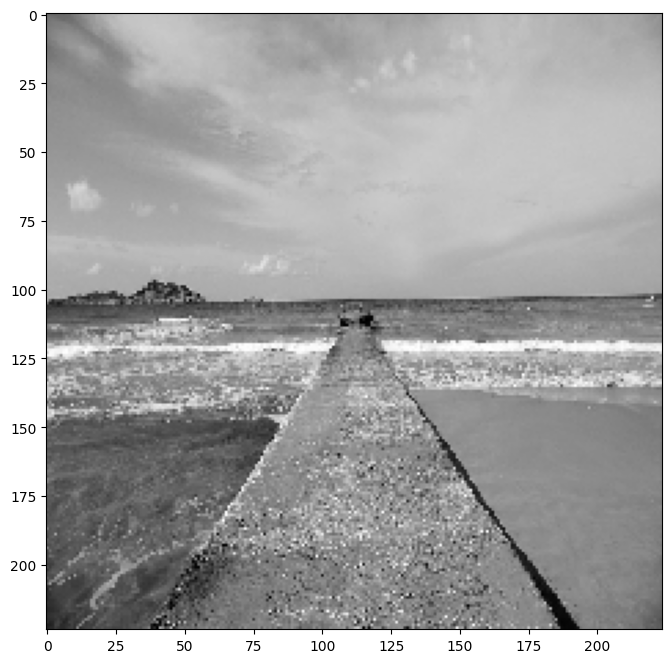

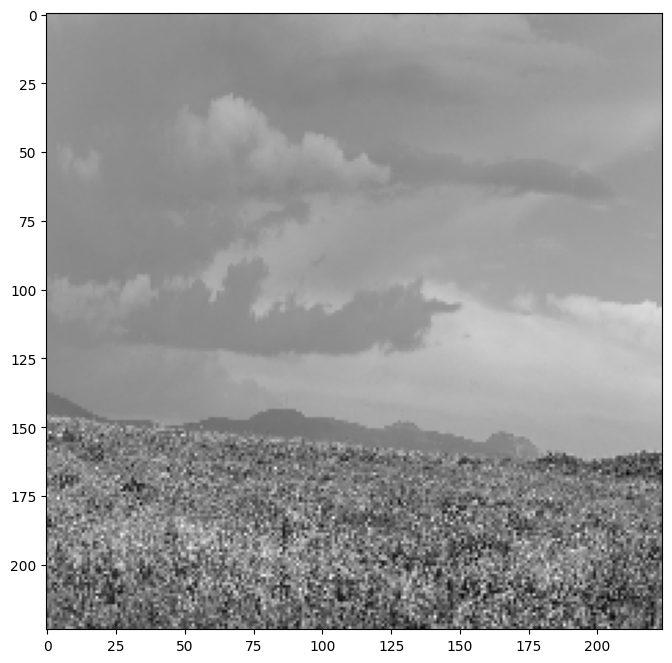

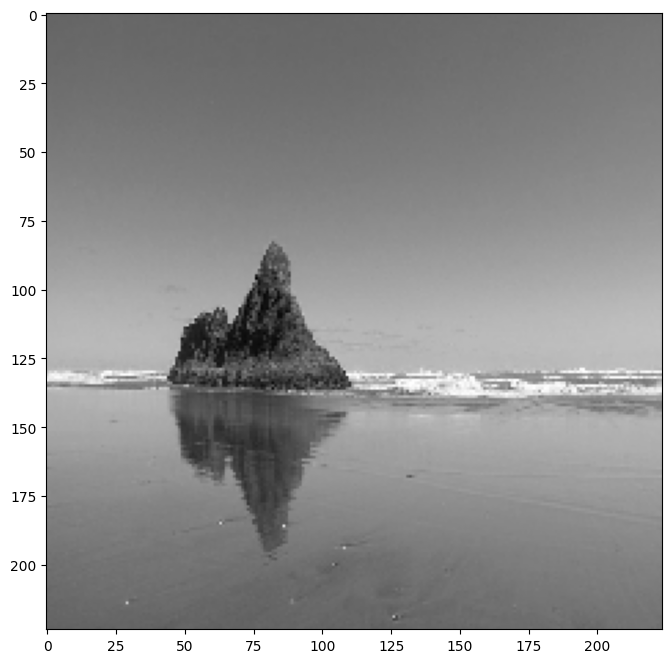

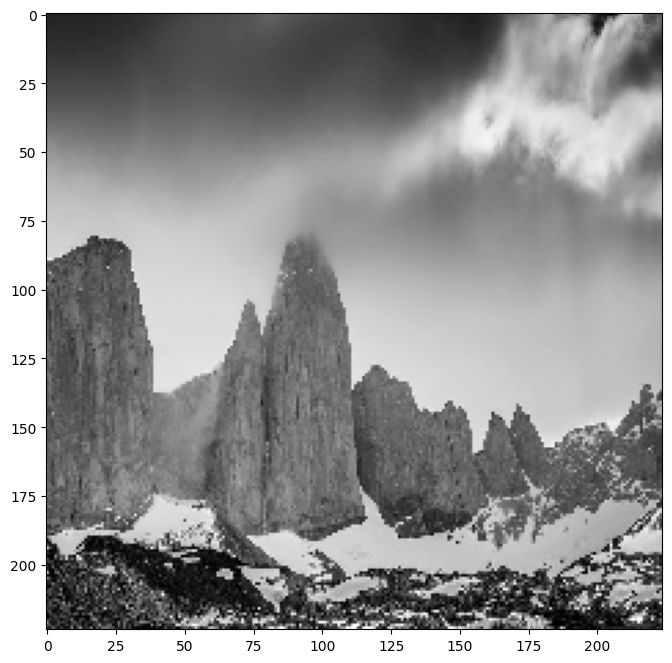

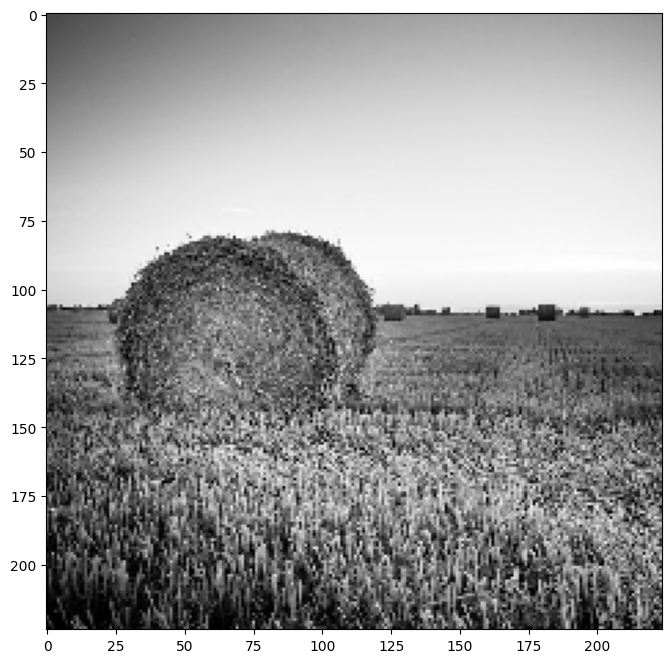

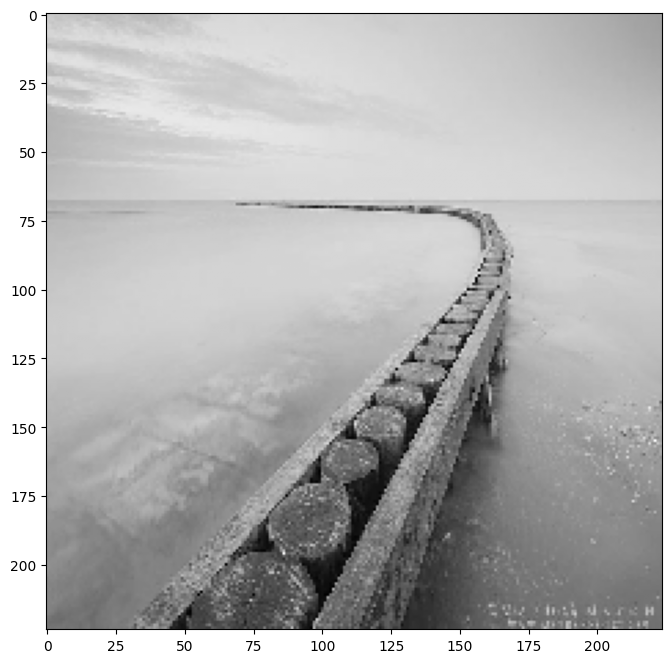

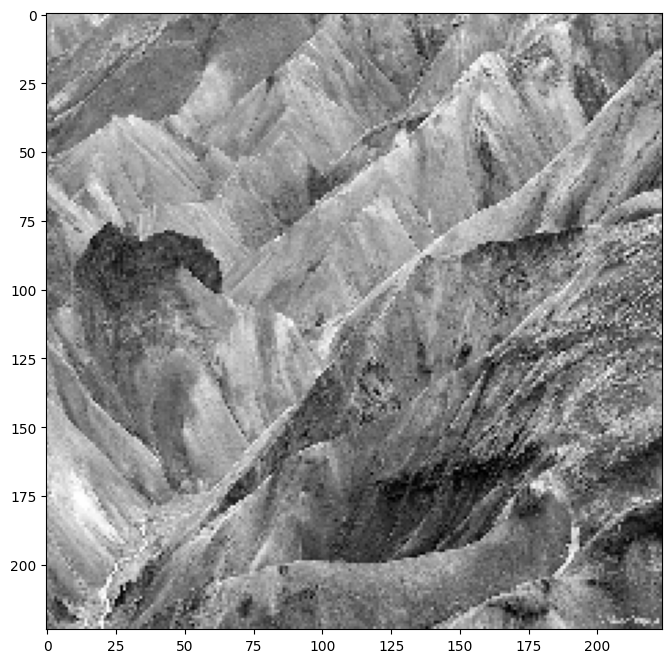

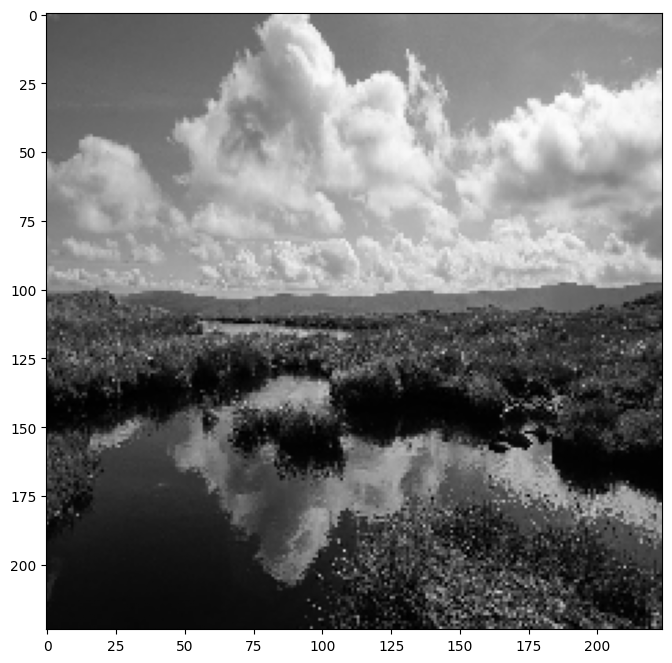

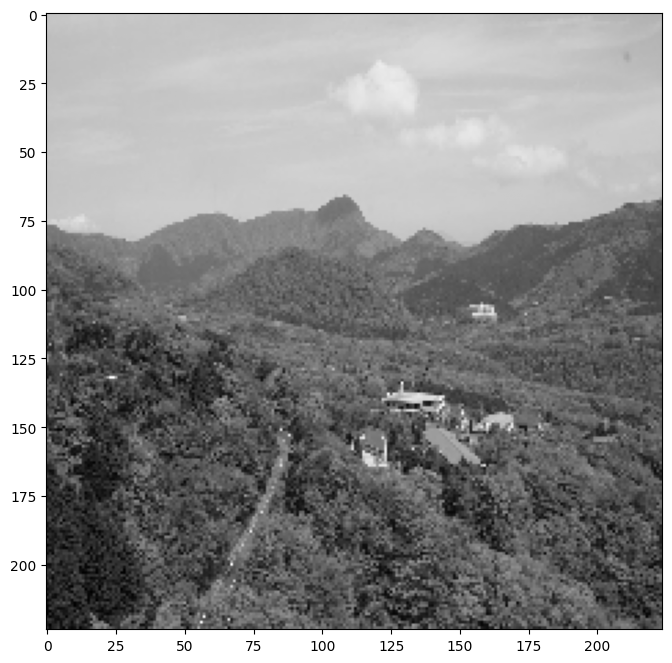

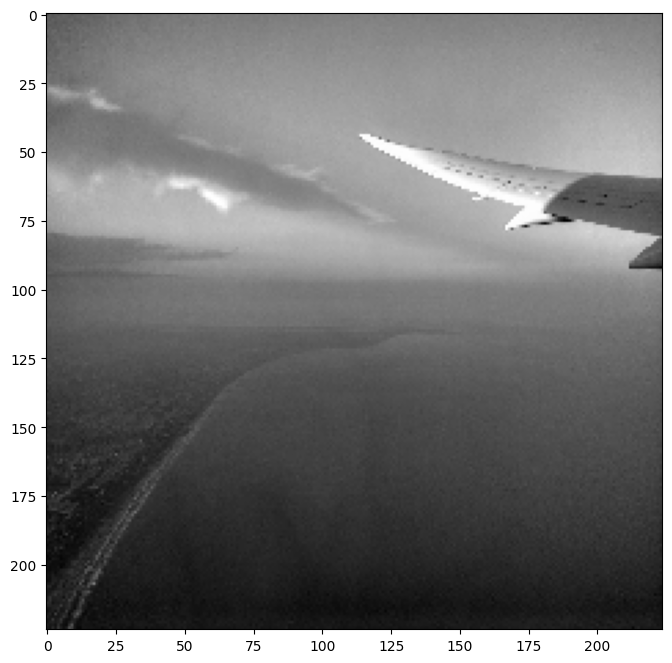

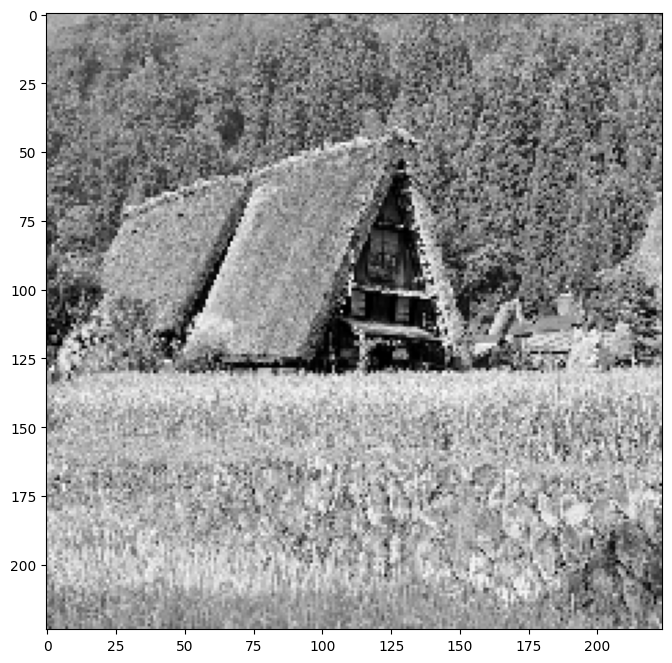

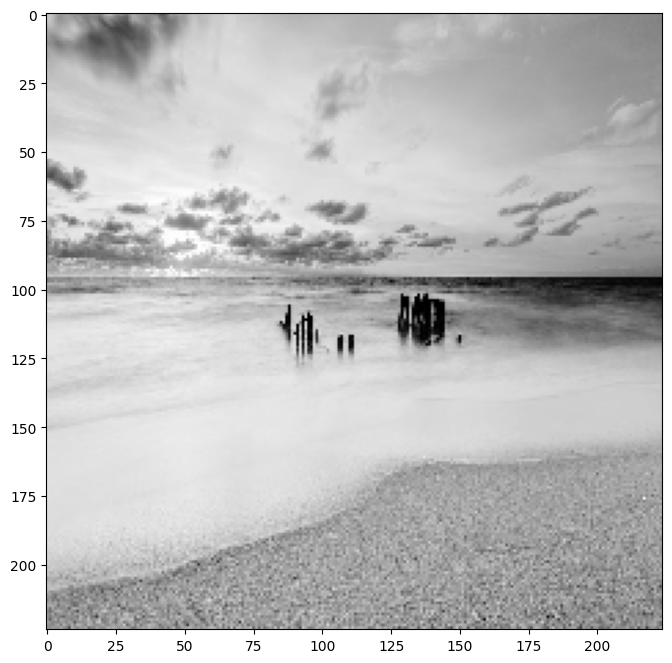

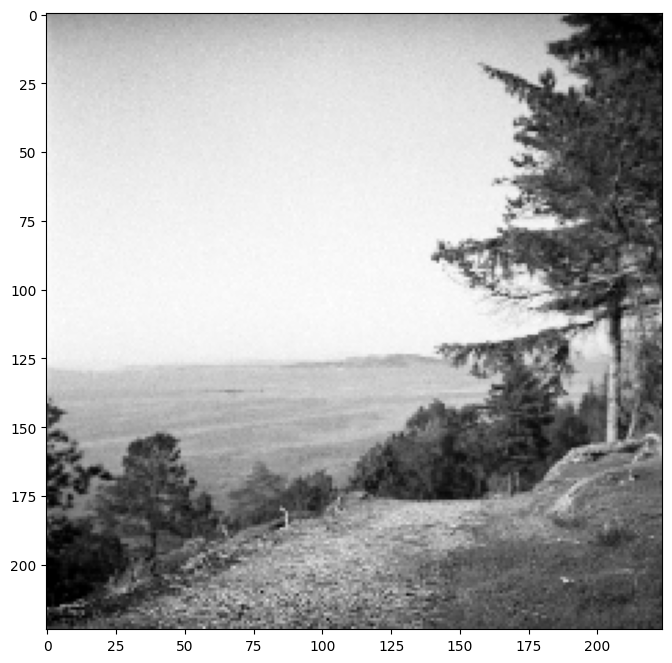

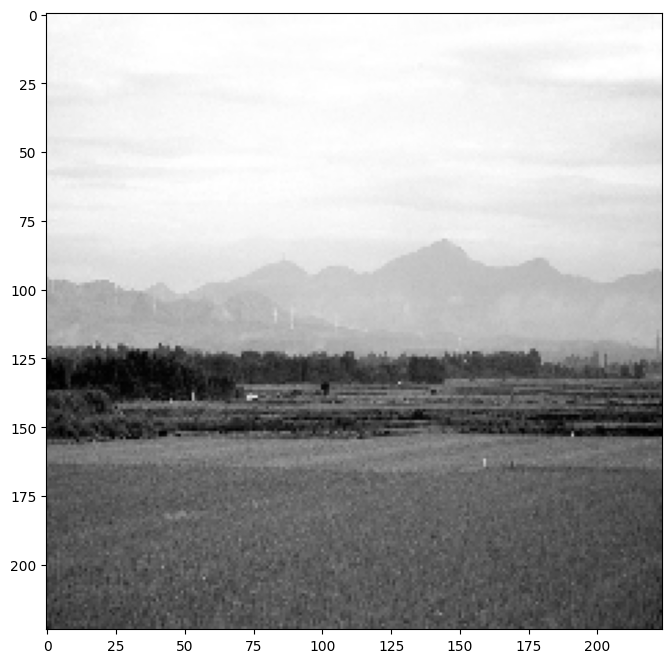

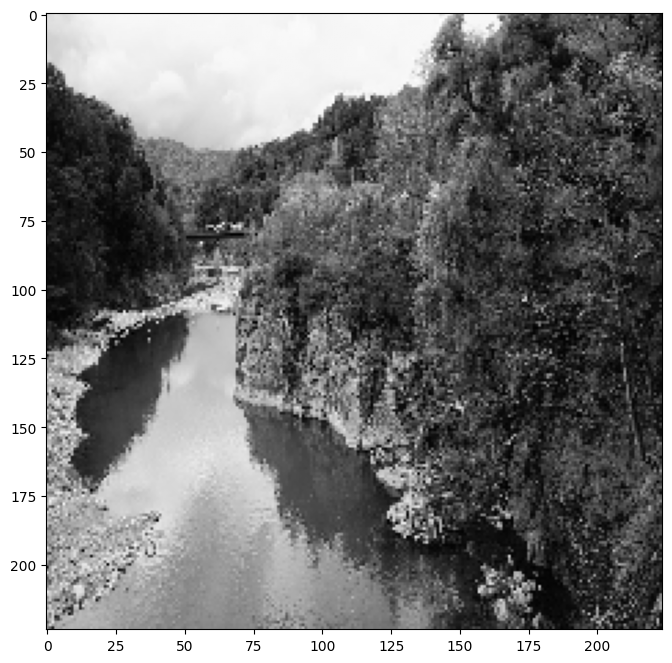

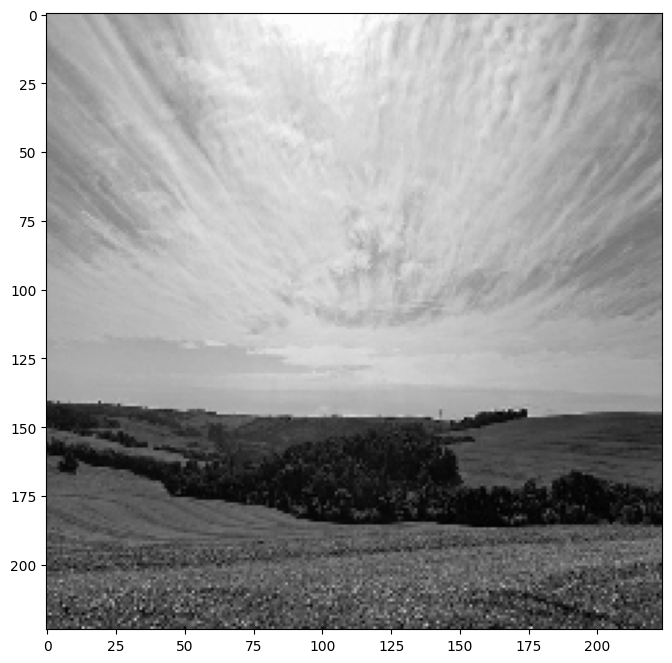

In [ ]:
# plotting the L channel
for i in batch_of_images :
  plot_image(convert_lab(i)[:,:,0])

## 4-Creating Training and Validation Sets from Preprocessed Images

In [ ]:
x_train=[]
y_train=[]
for i in tqdm(range(230)) :
  for image in train[i] :
    try :
      lab_image=convert_lab(image)
      x_train.append(lab_image[:,:,0])
      y_train.append(lab_image[:,:,1:]/128)
    except :
      print("Unexpected error. Maybe broken image.")
x_train=np.array(x_train)
y_train=np.array(y_train)
print(x_train.shape)
print(y_train.shape)

<ipython-input-15-2419593324a4>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(230)) :


  0%|          | 0/230 [00:00<?, ?it/s]

(3680, 224, 224)
(3680, 224, 224, 2)


In [ ]:
x_val=[]
y_val=[]
for i in tqdm(range(40)) :
  for image in val[i] :
    try :
      lab_image = convert_lab(image)
      x_val.append(lab_image[:,:,0])
      y_val.append(lab_image[:,:,1:]/128)
    except :
      print("Unexpected error. Maybe broken image.")
x_val=np.array(x_val)
y_val=np.array(y_val)
print(x_val.shape)
print(y_val.shape)

<ipython-input-16-3600c1a975af>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(40)) :


  0%|          | 0/40 [00:00<?, ?it/s]

(640, 224, 224)
(640, 224, 224, 2)


In [ ]:
x_train=x_train.reshape(x_train.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
x_val=x_val.reshape(x_val.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(3680, 224, 224, 1)
(3680, 224, 224, 2)
(640, 224, 224, 1)
(640, 224, 224, 2)


In [ ]:
np.save('/content/drive/MyDrive/ColabModels/x_train.npy', x_train)
np.save('/content/drive/MyDrive/ColabModels/y_train.npy', y_train)
np.save('/content/drive/MyDrive/ColabModels/x_val.npy', x_val)
np.save('/content/drive/MyDrive/ColabModels/y_val.npy', y_val)


In [ ]:
x_train = np.load('/content/drive/MyDrive/ColabModels/x_train.npy')
y_train = np.load('/content/drive/MyDrive/ColabModels/y_train.npy')
x_val = np.load('/content/drive/MyDrive/ColabModels/x_val.npy')
y_val = np.load('/content/drive/MyDrive/ColabModels/y_val.npy')


## 5-Deep Learning Architecture

In [ ]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor= "loss", factor=0.5, patience=10,
                                                 min_lr = 0.000001, verbose=1)
monitor_es=tf.keras.callbacks.EarlyStopping(monitor= "loss", patience=25, restore_best_weights= False, verbose = True)

In [ ]:
# transfer learning
vgg_model=tf.keras.applications.vgg16.VGG16()
transfer_learned_encoder_model = tf.keras.models.Sequential()
for i, layer in enumerate(vgg_model.layers):
  if i<19 :
    transfer_learned_encoder_model.add(layer)
for layer in transfer_learned_encoder_model.layers:
  layer.trainable=False

transfer_learned_encoder_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
vgg_features=[]
for i, image in tqdm(enumerate(x_train)) :
  image=cv2.merge((image, image, image))
  image=image.reshape((1,IMAGE_SIZE[0],IMAGE_SIZE[1],3))
  prediction=transfer_learned_encoder_model.predict(image)
  prediction=prediction.reshape((7,7,512))
  vgg_features.append(prediction)
vgg_features=np.array(vgg_features)
print(vgg_features.shape)

<ipython-input-22-e874a8df75e5>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, image in tqdm(enumerate(x_train)) :


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
# Encoder
input_shape=(7, 7, 512)
i=tf.keras.layers.Input(shape = input_shape)

#decoder
output=tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(i)
output=tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(i)
output=tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(i)
output=tf.keras.layers.UpSampling2D((2,2))(output)
output=tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(output)
output=tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(output)
output=tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(output)
output=tf.keras.layers.UpSampling2D((2,2))(output)
output=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(output)
output=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(output)
output=tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(output)
output=tf.keras.layers.UpSampling2D((2,2))(output)
output=tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu")(output)
output=tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu")(output)
output=tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu")(output)
output=tf.keras.layers.UpSampling2D((2,2))(output)
output=tf.keras.layers.Conv2D(filters=2, kernel_size=(3,3), padding="same", activation="tanh")(output)
output=tf.keras.layers.UpSampling2D((2,2))(output)

decoder_model=tf.keras.models.Model(inputs=i, outputs=output)
decoder_model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 2)    │           290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 224, 224, 2)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 784,114 (2.99 MB)

 Trainable params: 784,114 (2.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
decoder_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="MSE",
    metrics=["accuracy"]
)


In [ ]:
vgg_features.shape

(3680, 7, 7, 512)

In [ ]:
y_train.shape

(3680, 224, 224, 2)

In [ ]:
!mkdir -p /content/drive/MyDrive/ColabModels
transfer_learned_encoder_model.save('/content/drive/MyDrive/ColabModels/encoder_model2.keras')

In [ ]:
np.save('/content/drive/MyDrive/ColabModels/vgg_features2.npy', vgg_features)

In [ ]:
from tensorflow.keras.models import load_model

# Path to your saved model
model_path = '/content/drive/MyDrive/ColabModels/encoder_model.keras'

# Load the model
loaded_encoder_model = load_model(model_path)

# Now you can use the loaded model
# For example, to check the model summary:
loaded_encoder_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
EPOCHS=140
with tf.device("/device:GPU:0"):
  history = decoder_model.fit(vgg_features, y_train, epochs = EPOCHS, verbose = 1,
                      callbacks = [reduce_lr, monitor_es], batch_size = BATCH_SIZE)

Epoch 1/140
230/230 ━━━━━━━━━━━━━━━━━━━━ 153s 638ms/step - accuracy: 0.6298 - loss: 0.0156 - learning_rate: 0.0010
Epoch 2/140
230/230 ━━━━━━━━━━━━━━━━━━━━ 148s 643ms/step - accuracy: 0.6956 - loss: 0.0124 - learning_rate: 0.0010
Epoch 3/140
230/230 ━━━━━━━━━━━━━━━━━━━━ 200s 634ms/step - accuracy: 0.7031 - loss: 0.0113 - learning_rate: 0.0010
Epoch 4/140
230/230 ━━━━━━━━━━━━━━━━━━━━ 208s 656ms/step - accuracy: 0.7130 - loss: 0.0105 - learning_rate: 0.0010
Epoch 5/140
230/230 ━━━━━━━━━━━━━━━━━━━━ 197s 638ms/step - accuracy: 0.7182 - loss: 0.0098 - learning_rate: 0.0010
Epoch 6/140
230/230 ━━━━━━━━━━━━━━━━━━━━ 202s 638ms/step - accuracy: 0.7379 - loss: 0.0093 - learning_rate: 0.0010
Epoch 7/140
230/230 ━━━━━━━━━━━━━━━━━━━━ 202s 637ms/step - accuracy: 0.7409 - loss: 0.0086 - learning_rate: 0.0010
Epoch 8/140
230/230 ━━━━━━━━━━━━━━━━━━━━ 202s 639ms/step - accuracy: 0.7512 - loss: 0.0080 - learning_rate: 0.0010
Epoch 9/140
230/230 ━━━━━━━━━━━━━━━━━━━━ 144s 628ms/step - accuracy: 0.7566 - lo

In [ ]:
decoder_model.save('/content/drive/MyDrive/ColabModels/decoder_model2.keras')

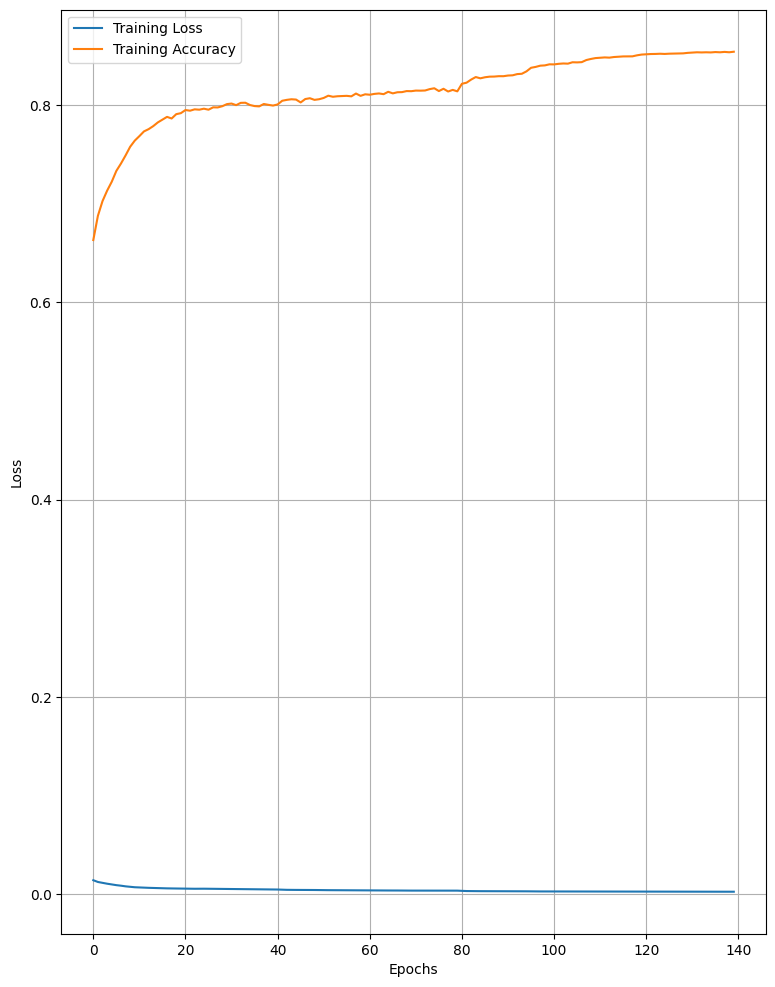

In [ ]:
x = np.arange(0, EPOCHS, 1)
plt.figure(1, figsize = (20, 12))
plt.subplot(121)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x, history.history["loss"], label = "Training Loss")
plt.plot(x, history.history["accuracy"], label = "Training Accuracy")
plt.grid(True)
plt.legend()

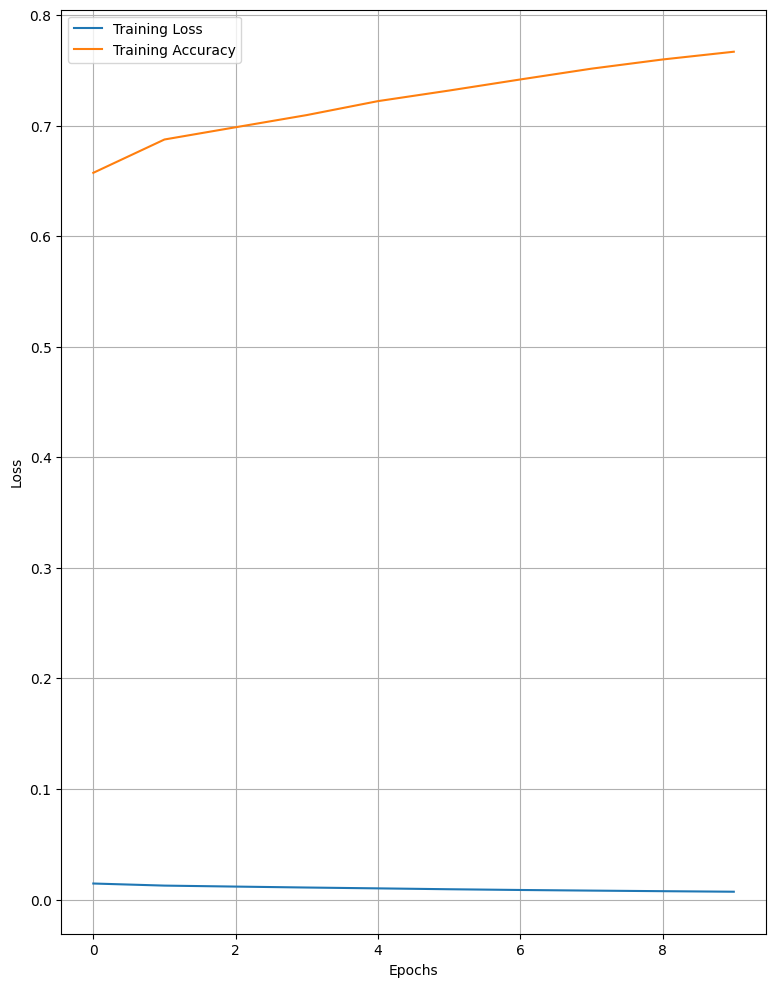

In [ ]:
x = np.arange(0, EPOCHS, 1)
plt.figure(1, figsize = (20, 12))
plt.subplot(121)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x, history.history["loss"], label = "Training Loss")
plt.plot(x, history.history["accuracy"], label = "Training Accuracy")
plt.grid(True)
plt.legend()

In [ ]:
validation_images = x_val[:15]
vgg_features_val = []
for i, image in tqdm(enumerate(validation_images)) :
  image = cv2.merge((image, image, image))
  image = image.reshape((1,IMAGE_SIZE[0],IMAGE_SIZE[1],3))
  prediction = transfer_learned_encoder_model.predict(image)
  prediction = prediction.reshape((7,7,512))
  vgg_features_val.append(prediction)
vgg_features_val=np.array(vgg_features_val)
print(vgg_features_val.shape)

<ipython-input-32-d64f2611ef8e>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, image in tqdm(enumerate(validation_images)) :


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
(15, 7, 7, 512)


In [ ]:
ab_pred=decoder_model.predict(vgg_features_val)
ab_pred=ab_pred * 128
print(ab_pred.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
(15, 224, 224, 2)


In [ ]:
print(validation_images.shape)

(15, 224, 224, 1)


In [ ]:
for i in range(validation_images.shape[0]) :
  image=validation_images[i]
  image=image.reshape((IMAGE_SIZE[0] , IMAGE_SIZE[1]))

  reconstructed_image=np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
  reconstructed_image[:,:,0]=image
  reconstructed_image[:,:,1:]=ab_pred[i]

  #reconstructed_image = reconstructed_image.astype(np.uint8)
  reconstructed_image=convert_rgb(reconstructed_image)

  image = cv2.resize(image, (1024, 1024))
  reconstructed_image=cv2.resize(reconstructed_image, (1024, 1024))

  plot_image(image)
  plot_image(reconstructed_image)